# Forecasting Airline Passengers Dataset

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt,ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

### Reading Airlines Dataset

In [2]:
df = pd.read_excel("Airlines+Data.xlsx",index_col='Month',parse_dates=True)

In [3]:
df.head()

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121


In [4]:
df.tail()

,Passengers
Month,
2002-08-01,405
2002-09-01,355
2002-10-01,306
2002-11-01,271
2002-12-01,306


In [5]:
df.index.freq = 'MS' # changing freq to monthly start i.e. MS

In [6]:
df.head().index

DatetimeIndex(['1995-01-01', '1995-02-01', '1995-03-01', '1995-04-01',
               '1995-05-01'],
              dtype='datetime64[ns]', name='Month', freq='MS')

The data represents monthly average passengers starting January 1995 to december 2002.

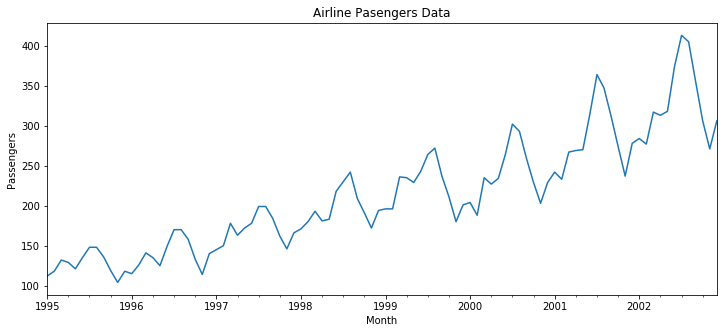

In [7]:
# Creating Line chart to visualize data.
title='Airline Pasengers Data'
ylabel='Passengers'
ax = df['Passengers'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(ylabel=ylabel);

We see a gradual increase in passenger with some seasonal variations.
Lets us plot using seasonal decompose to very seasonality in data.

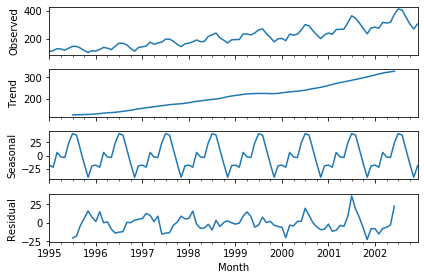

In [8]:
result = seasonal_decompose(df['Passengers'], model='add')
result.plot();

We can see a linear trend and seasonality in data, when observed through ETS decomposition.

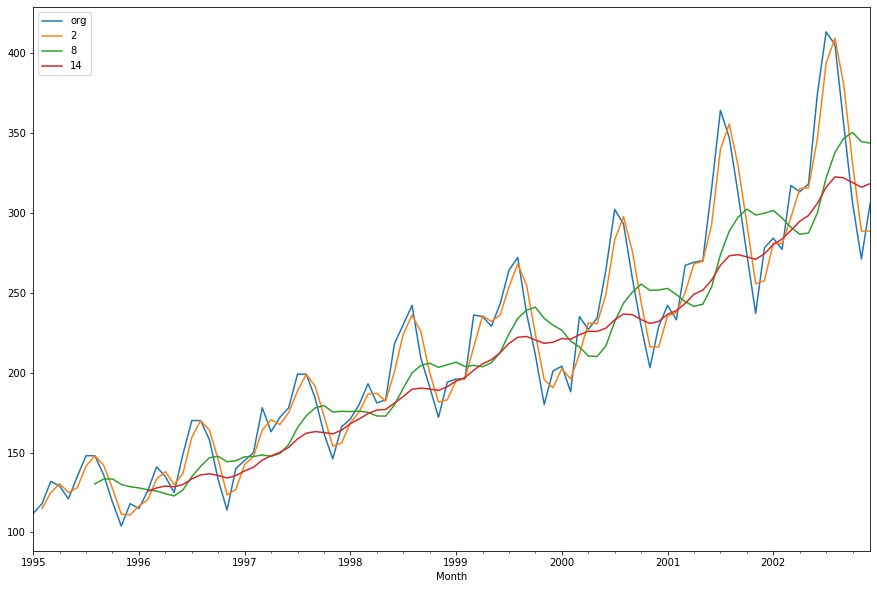

In [9]:
# moving average for the time series to understand better about the trend character in Airlines
import matplotlib.pyplot as plt
df.Passengers.plot(label="org",figsize=(15,10))
for i in range(2,15,6):
    df["Passengers"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='upper left');

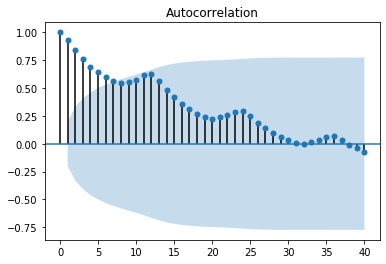

In [10]:
# ACF plots and PACF plots on Original data sets 
plot_acf(df.Passengers,lags=40);

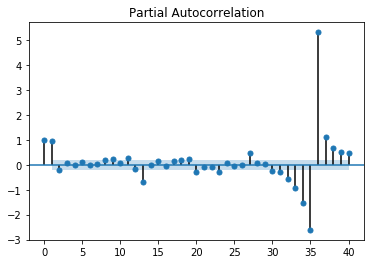

In [11]:
plot_pacf(df.Passengers,lags=40);

Splitting the data into Train and Test data and considering the last 12 months data as Test data and left over data as train data

In [12]:
train = df[:len(df)-12]
test = df[len(df)-12:]

Lets try some model on airline data

In [13]:
#Simple Exponential Smoothing
ses_model = SimpleExpSmoothing(train["Passengers"]).fit()
pred_ses = ses_model.predict(start = test.index[0],end = test.index[-1]).rename("Pred_SES")
ses_rmse = rmse(pred_ses,test.Passengers)
print(ses_rmse)

68.00673986206563


In [14]:
# Holts winter exponential smoothing with additive seasonality and additive trend
hwe_model_add_add = ExponentialSmoothing(train["Passengers"],seasonal="add",trend="add",seasonal_periods=12,damped=True).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = test.index[0],end = test.index[-1]).rename("hwe_model_add_add")
hwe_model_add_add_rmse = rmse(pred_hwe_add_add,test.Passengers)
print(hwe_model_add_add_rmse)

7.97274576528449


In [15]:
# Holt method 
hw_model = Holt(train["Passengers"]).fit()
pred_hw = hw_model.predict(start = test.index[0],end = test.index[-1]).rename("hw_model")
hw_model_rmse = rmse(pred_hw,test.Passengers)
print(hw_model_rmse)

58.57971618191826


In [16]:
# Lets us use auto_arima
auto_arima_model = auto_arima(train["Passengers"],m=12,seasonal=True)
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   84
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood                -264.027
Date:                            Tue, 22 Jun 2021   AIC                            536.054
Time:                                    13:30:29   BIC                            545.160
Sample:                                         0   HQIC                           539.679
                                             - 84                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      8.9067      3.173      2.807      0.005       2.688      15.126
ar.L1          0.7430      0.098      7.566      0.000       0.551       0.935
ar.S.L12      -0.3174      0.128     -2.480      0.013      -0.568      -0.067
sigma2        87.1453     15.199      5.734      0.000      57.356     116.935
===================================================================================
Ljung-Box (Q):                       36.84   Jarque-Bera (JB):                 3.03
Prob(Q):                              0.61   Prob(JB):                         0.22
Heteroskedasticity (H):               2.45   Skew:                             0.48
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We see a recommended ARIMA Order of (1,0,0) combined with a seasonal order of (1,1,0,12).

In [17]:
sarima_model = SARIMAX(train['Passengers'],order=(0,1,0),seasonal_order=(1,1,0,12),enforce_stationarity=False).fit()
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                         Passengers   No. Observations:                   84
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -222.939
Date:                            Tue, 22 Jun 2021   AIC                            449.878
Time:                                    13:30:29   BIC                            454.033
Sample:                                01-01-1995   HQIC                           451.500
                                     - 12-01-2001                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.3039      0.110     -2.757      0.006      -0.520      -0.088
sigma2       112.0978     23.733      4.723      0.000      65.582     158.614
===================================================================================
Ljung-Box (Q):                       41.03   Jarque-Bera (JB):                 1.67
Prob(Q):                              0.43   Prob(JB):                         0.43
Heteroskedasticity (H):               1.19   Skew:                             0.31
Prob(H) (two-sided):                  0.70   Kurtosis:                         2.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
pred_sarima = sarima_model.predict(start = test.index[0],end = test.index[-1]).rename("sarima_model")
sarima_rmse = rmse(pred_sarima,test.Passengers)
print(sarima_rmse)

10.141537831556295


In [19]:
model_review = pd.DataFrame(data=[ses_rmse,hw_model_rmse,hwe_model_add_add_rmse,sarima_rmse],
                                  columns=["RMSE"],index=['ses_model','hw_model','hwe_model_add_add','sarima_model'])

In [20]:
model_review

,RMSE
ses_model,68.006740
hw_model,58.579716
hwe_model_add_add,7.972746
sarima_model,10.141538


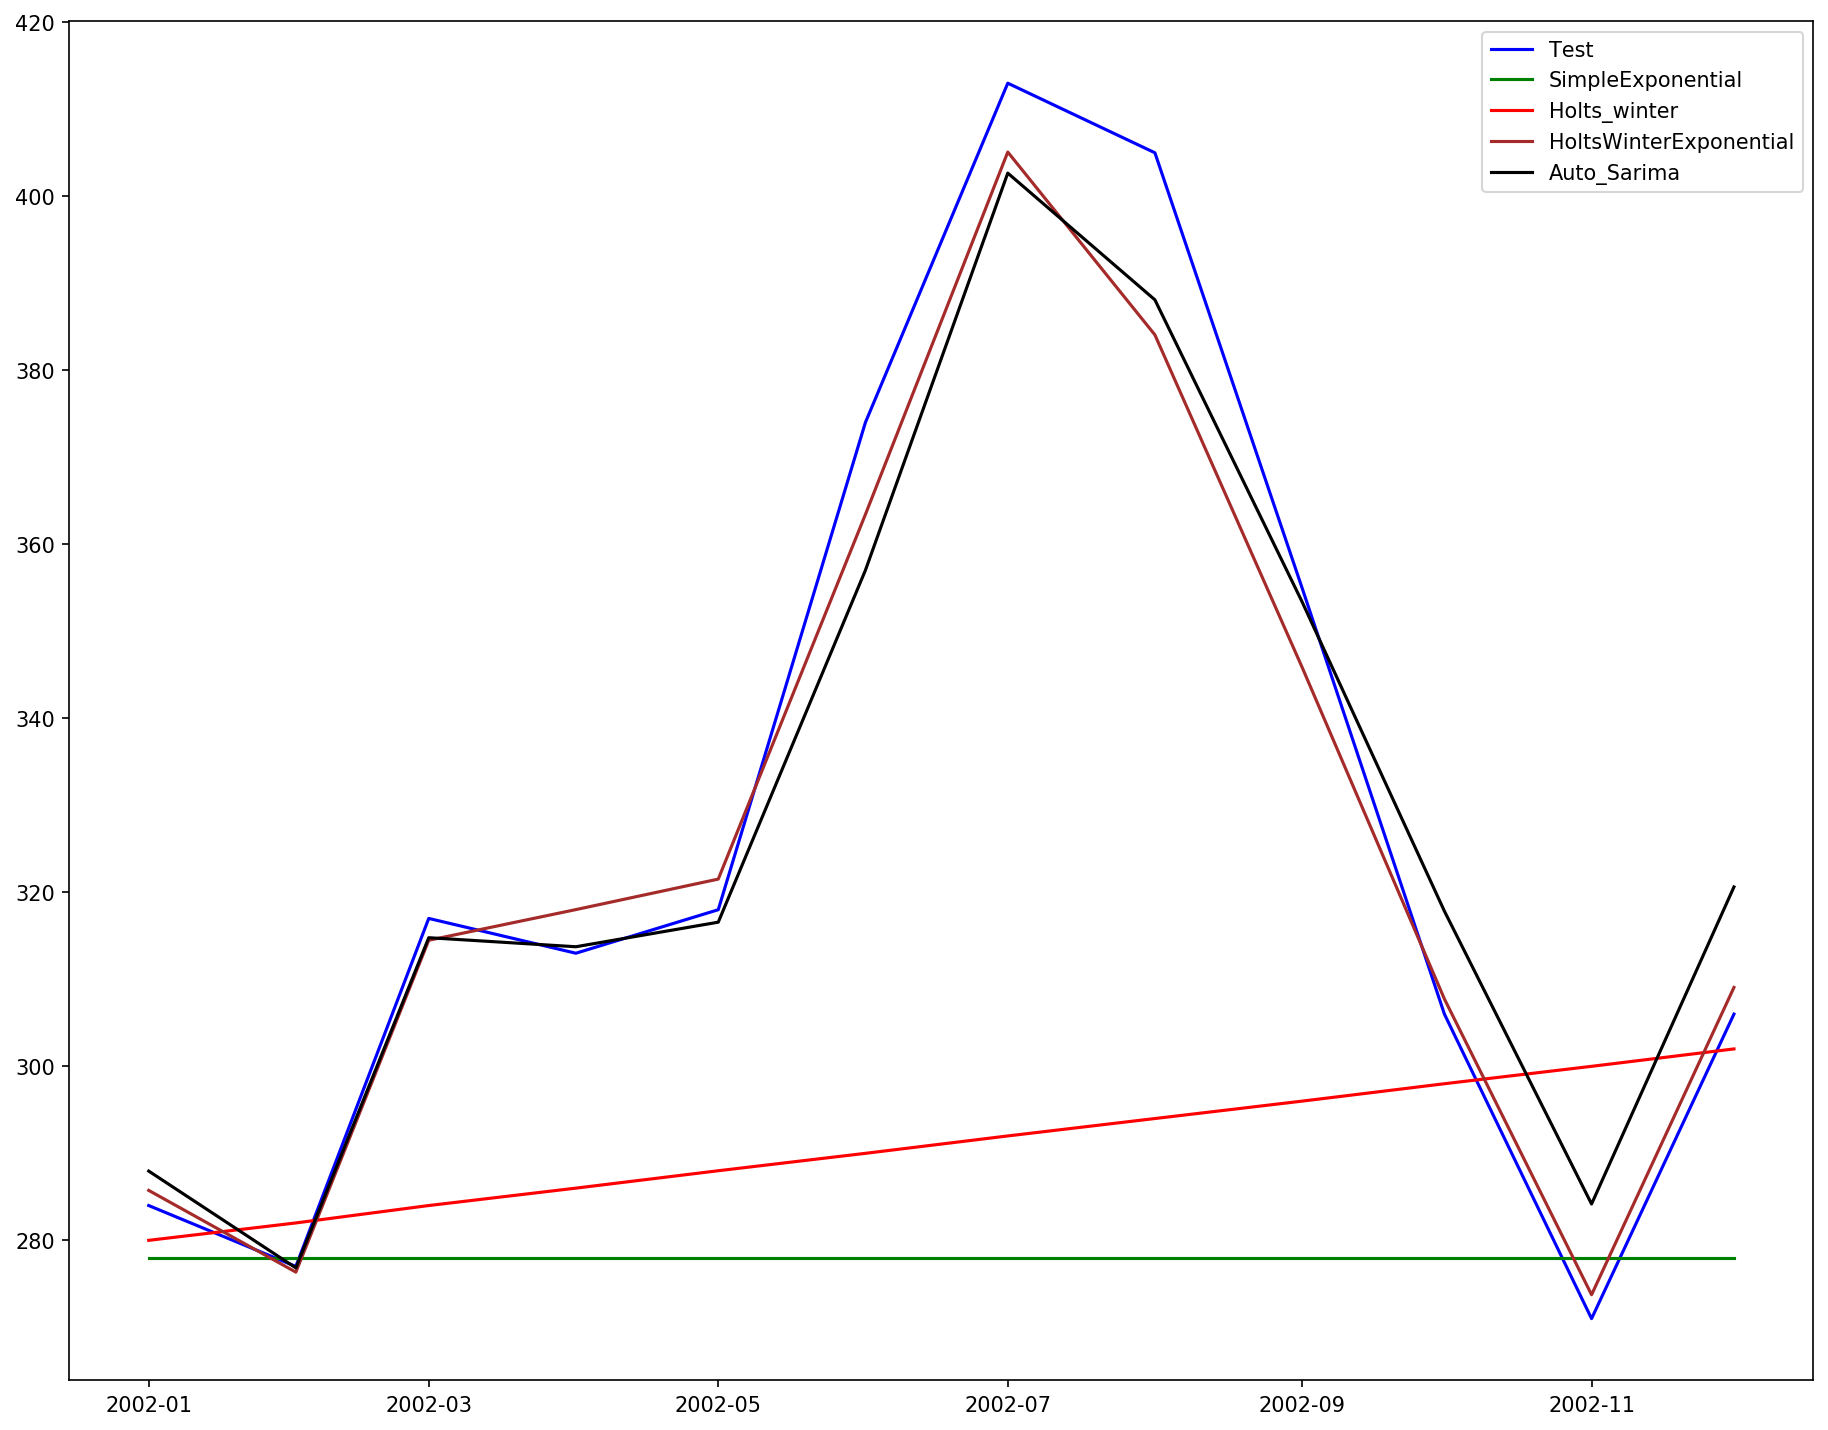

In [21]:
# Visualization of Forecasted values for Test data set using different methods 
plt.figure(figsize=(15,12),dpi=150)
plt.plot(test.index, test["Passengers"], label='Test',color="blue")
plt.plot(pred_ses.index, pred_ses, label='SimpleExponential',color="green")
plt.plot(pred_hw.index, pred_hw, label='Holts_winter',color="red")
plt.plot(pred_hwe_add_add.index,pred_hwe_add_add,label="HoltsWinterExponential",color="brown")
plt.plot(pred_sarima.index,pred_sarima,label="Auto_Sarima",color="black")
plt.legend(loc='best')

By seeing above graph and rmse table we can choose holtwinter exponetial smoothing with additive seaonality as our model for forecasting.

### Retraining on full dataset

In [22]:
# Holts winter exponential smoothing with additive seasonality and additive trend
Final_model = ExponentialSmoothing(df.Passengers,seasonal="add",trend="add",seasonal_periods=12,damped=True).fit()

In [23]:
fcast = Final_model.predict(len(df),len(df)+11).rename('Holts winter exponential smoothing Forecast')

In [24]:
fcast

2003-01-01    320.924021
2003-02-01    313.638039
2003-03-01    352.925020
2003-04-01    350.350301
2003-05-01    356.060923
2003-06-01    408.899129
2003-07-01    446.143114
2003-08-01    433.358026
2003-09-01    382.762460
2003-10-01    336.170254
2003-11-01    303.315050
2003-12-01    349.662471
Freq: MS, Name: Holts winter exponential smoothing Forecast, dtype: float64

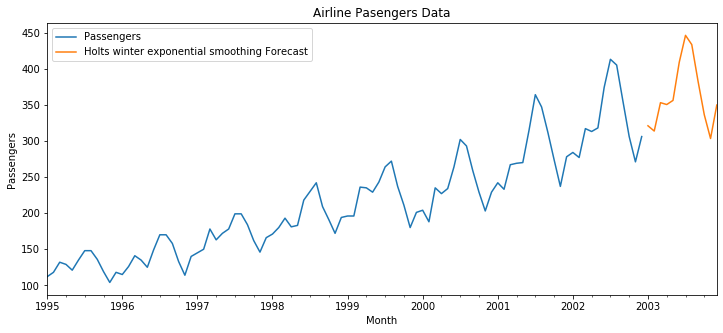

In [25]:
title='Airline Pasengers Data'
ylabel='Passengers'
ax = df['Passengers'].plot(figsize=(12,5),title=title,legend=True)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(ylabel=ylabel);